# Flux Sweeping via SRS

[srsinst pacakge](https://github.com/thinkSRS/srsinst.dc205)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from flux_fit import *
from utils import *

Connect to the instruments

In [4]:
!python -m srsinst.dc205

In [5]:
client = Labber.connectToServer(timeout=None)
instrument_list = client.getListOfInstruments()
instruments = create_instrument_connections(client, instrument_list)

Successfully connected to Agilent Network Analyzer E5071B
Successfully connected to HP Spectrum Analyzer
Successfully connected to Keithley 2400 SourceMeter
Successfully connected to Manual
Successfully connected to Rohde&Schwarz RF Source
Successfully connected to SignalCore SC5511A Signal Generator_10002F25
Successfully connected to SignalCore SC5511A Signal Generator_1000334C
Successfully connected to Vaunix Lab Brick Digital Attenuator


In [6]:
vs = connect_SRS()
VNA = instruments['Agilent Network Analyzer E5071B']
DA = instruments['Vaunix Lab Brick Digital Attenuator']
SMU = instruments['Keithley 2400 SourceMeter']
LO= instruments['SignalCore SC5511A Signal Generator_10002F25']
Drive= instruments['SignalCore SC5511A Signal Generator_1000334C']
TWPA_PUMP = instruments['Rohde&Schwarz RF Source']
SA = instruments["HP Spectrum Analyzer"]

initialize_instruments(VNA, DA, SMU, LO, Drive, vs, TWPA_PUMP, SA)

Since we only need the VNA and SRS for this measurement- lets make sure they are connected and ready to go. 

In [7]:
vs.check_id()


('DC205', 's/n20500691', 'ver1.80')

In [8]:
VNA.isRunning()

True

Setting up the paths for storing the Labber file.

In [9]:
# get the time module
import time
import os
import logging

SPATH = r"G:\Shared drives\Labber\Data\{}\{}\Data_{}\\".format(time.strftime("%Y"), time.strftime("%m"), time.strftime("%m%d"))

figpath = SPATH + r"Figures\\"
if not os.path.exists(figpath):
    os.makedirs(figpath)
print(f"Saving path of Labber data to {SPATH}")
print(f"Saving figures to {figpath}")
logging.basicConfig(filename=SPATH+f'MEASUREMENTLOG_{time.strftime("%Y%m%d_%H%M%S")}.log',filemode='w',level=logging.INFO)


Saving path of Labber data to G:\Shared drives\Labber\Data\2025\04\Data_0411\\
Saving figures to G:\Shared drives\Labber\Data\2025\04\Data_0411\\Figures\\


Either set the VNA settings manually and grab them.

In [ ]:
VNA.getInstrConfig()

Or just set them in the code. 

```python

In [24]:
VNA.setValue('Output enabled',True)
VNA.setValue('Range type','Start - Stop')
VNA.setValue('Start frequency', 5.7E9)
VNA.setValue('Stop frequency', 5.8E9)
VNA.setValue('# of averages', 100)
VNA.setValue('Average',True)
VNA.setValue('Wait for new trace', True)
VNA.setValue('Trigger', True)

True

Testing the VNA settings by grabbing a trace

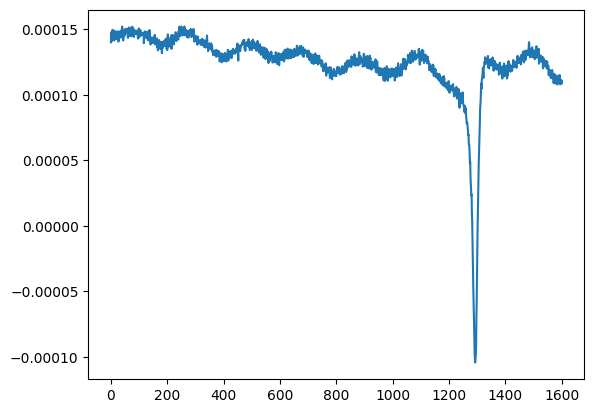

In [13]:
dBG = VNA.getValue('S21')
xBG = np.arange(dBG['t0'],dBG['t0']+dBG['shape'][0]*dBG['dt'],dBG['dt'])
zBG = dBG['y']
plt.plot(zBG)
plt.show()

In [25]:
voltages = np.arange(-74E-3,72E-3,2E-3)
#voltages = np.arange(0,4E-3,2E-3)

# reverse order
#voltages = np.flip(voltages)
voltages, len(voltages)

(array([-7.4000000e-02, -7.2000000e-02, -7.0000000e-02, -6.8000000e-02,
        -6.6000000e-02, -6.4000000e-02, -6.2000000e-02, -6.0000000e-02,
        -5.8000000e-02, -5.6000000e-02, -5.4000000e-02, -5.2000000e-02,
        -5.0000000e-02, -4.8000000e-02, -4.6000000e-02, -4.4000000e-02,
        -4.2000000e-02, -4.0000000e-02, -3.8000000e-02, -3.6000000e-02,
        -3.4000000e-02, -3.2000000e-02, -3.0000000e-02, -2.8000000e-02,
        -2.6000000e-02, -2.4000000e-02, -2.2000000e-02, -2.0000000e-02,
        -1.8000000e-02, -1.6000000e-02, -1.4000000e-02, -1.2000000e-02,
        -1.0000000e-02, -8.0000000e-03, -6.0000000e-03, -4.0000000e-03,
        -2.0000000e-03,  6.9388939e-17,  2.0000000e-03,  4.0000000e-03,
         6.0000000e-03,  8.0000000e-03,  1.0000000e-02,  1.2000000e-02,
         1.4000000e-02,  1.6000000e-02,  1.8000000e-02,  2.0000000e-02,
         2.2000000e-02,  2.4000000e-02,  2.6000000e-02,  2.8000000e-02,
         3.0000000e-02,  3.2000000e-02,  3.4000000e-02,  3.60000

In [26]:
labber_file_name = "NBRL1A_33mK"

lfVNA = Labber.createLogFile_ForData(os.path.join(SPATH, f'{labber_file_name}_flux_sweep'),
                                      [{'name':'VNA - S21','complex':True,'vector':True,'x_name':'Frequency','x_unit':'Hz'}],
                                      step_channels=[{'name':'Voltage','values':voltages,'unit':'V'}])

In [27]:
for voltage in tqdm(voltages, desc='Voltage Sweep', unit='V'):  # Add tqdm progress bar
    print(voltage)
    logging.info(f'Starting Voltage = {voltage:.3f}\\n')
    set_flux_bias_srs(voltage, step=5E-5)
    sleep(0.05)
    dData = VNA.getValue('S21')
    zData = dData['y']
    xBG = np.arange(dData['t0'],dData['t0']+dData['shape'][0]*dData['dt'],dData['dt'])
    td2 = Labber.getTraceDict(zData,x0=xBG[0],x1=xBG[-1])
    lfVNA.addEntry({'VNA - S21':td2})

Voltage Sweep:   0%|          | 0/73 [00:00<?, ?V/s]

-0.074
Setting FFL bias to -74.0 mV from 0.0 mV


Voltage Sweep:   1%|▏         | 1/73 [12:37<15:08:36, 757.17s/V]

-0.072
Setting FFL bias to -72.0 mV from -74.0 mV


Voltage Sweep:   3%|▎         | 2/73 [15:44<8:19:31, 422.13s/V] 

-0.06999999999999999
Setting FFL bias to -69.99999999999999 mV from -72.0 mV


Voltage Sweep:   4%|▍         | 3/73 [18:52<6:07:33, 315.04s/V]

-0.06799999999999999
Setting FFL bias to -67.99999999999999 mV from -70.0 mV


Voltage Sweep:   5%|▌         | 4/73 [21:59<5:04:23, 264.69s/V]

-0.06599999999999999
Setting FFL bias to -65.99999999999999 mV from -68.0 mV


Voltage Sweep:   7%|▋         | 5/73 [25:07<4:28:28, 236.89s/V]

-0.06399999999999999
Setting FFL bias to -63.999999999999986 mV from -66.0 mV


Voltage Sweep:   8%|▊         | 6/73 [28:15<4:05:48, 220.13s/V]

-0.061999999999999986
Setting FFL bias to -61.999999999999986 mV from -64.0 mV


Voltage Sweep:  10%|▉         | 7/73 [31:22<3:50:26, 209.49s/V]

-0.059999999999999984
Setting FFL bias to -59.999999999999986 mV from -62.0 mV


Voltage Sweep:  11%|█         | 8/73 [34:30<3:39:23, 202.51s/V]

-0.05799999999999998
Setting FFL bias to -57.99999999999998 mV from -60.0 mV


Voltage Sweep:  12%|█▏        | 9/73 [37:37<3:31:01, 197.83s/V]

-0.05599999999999998
Setting FFL bias to -55.99999999999998 mV from -58.0 mV


Voltage Sweep:  14%|█▎        | 10/73 [40:45<3:24:23, 194.66s/V]

-0.05399999999999998
Setting FFL bias to -53.99999999999998 mV from -56.0 mV


Voltage Sweep:  15%|█▌        | 11/73 [43:52<3:18:52, 192.47s/V]

-0.05199999999999998
Setting FFL bias to -51.99999999999998 mV from -54.0 mV


Voltage Sweep:  16%|█▋        | 12/73 [47:00<3:14:08, 190.96s/V]

-0.049999999999999975
Setting FFL bias to -49.99999999999997 mV from -52.0 mV


Voltage Sweep:  18%|█▊        | 13/73 [50:07<3:09:56, 189.95s/V]

-0.04799999999999997
Setting FFL bias to -47.99999999999997 mV from -50.0 mV


Voltage Sweep:  19%|█▉        | 14/73 [53:15<3:06:04, 189.23s/V]

-0.04599999999999997
Setting FFL bias to -45.99999999999997 mV from -48.0 mV


Voltage Sweep:  21%|██        | 15/73 [56:23<3:02:26, 188.73s/V]

-0.04399999999999997
Setting FFL bias to -43.99999999999997 mV from -46.0 mV


Voltage Sweep:  22%|██▏       | 16/73 [59:30<2:58:56, 188.35s/V]

-0.04199999999999997
Setting FFL bias to -41.999999999999964 mV from -44.0 mV


Voltage Sweep:  23%|██▎       | 17/73 [1:02:38<2:55:34, 188.11s/V]

-0.039999999999999966
Setting FFL bias to -39.999999999999964 mV from -42.0 mV


Voltage Sweep:  25%|██▍       | 18/73 [1:05:45<2:52:16, 187.93s/V]

-0.037999999999999964
Setting FFL bias to -37.999999999999964 mV from -40.0 mV


Voltage Sweep:  26%|██▌       | 19/73 [1:08:53<2:49:02, 187.82s/V]

-0.03599999999999996
Setting FFL bias to -35.999999999999964 mV from -38.0 mV


Voltage Sweep:  27%|██▋       | 20/73 [1:12:00<2:45:48, 187.71s/V]

-0.03399999999999996
Setting FFL bias to -33.99999999999996 mV from -36.0 mV


Voltage Sweep:  29%|██▉       | 21/73 [1:15:08<2:42:37, 187.65s/V]

-0.03199999999999996
Setting FFL bias to -31.999999999999957 mV from -34.0 mV


Voltage Sweep:  30%|███       | 22/73 [1:18:15<2:39:27, 187.59s/V]

-0.029999999999999957
Setting FFL bias to -29.999999999999957 mV from -32.0 mV


Voltage Sweep:  32%|███▏      | 23/73 [1:21:23<2:36:17, 187.56s/V]

-0.027999999999999955
Setting FFL bias to -27.999999999999954 mV from -30.0 mV


Voltage Sweep:  33%|███▎      | 24/73 [1:24:30<2:33:09, 187.53s/V]

-0.025999999999999954
Setting FFL bias to -25.999999999999954 mV from -28.0 mV


Voltage Sweep:  34%|███▍      | 25/73 [1:27:38<2:30:02, 187.55s/V]

-0.023999999999999952
Setting FFL bias to -23.99999999999995 mV from -26.0 mV


Voltage Sweep:  36%|███▌      | 26/73 [1:30:45<2:26:54, 187.55s/V]

-0.02199999999999995
Setting FFL bias to -21.99999999999995 mV from -24.0 mV


Voltage Sweep:  37%|███▋      | 27/73 [1:33:53<2:23:47, 187.56s/V]

-0.01999999999999995
Setting FFL bias to -19.999999999999947 mV from -22.0 mV


Voltage Sweep:  38%|███▊      | 28/73 [1:37:00<2:20:39, 187.55s/V]

-0.017999999999999947
Setting FFL bias to -17.999999999999947 mV from -20.0 mV


Voltage Sweep:  40%|███▉      | 29/73 [1:40:08<2:17:30, 187.51s/V]

-0.015999999999999945
Setting FFL bias to -15.999999999999945 mV from -18.0 mV


Voltage Sweep:  41%|████      | 30/73 [1:43:15<2:14:23, 187.52s/V]

-0.013999999999999943
Setting FFL bias to -13.999999999999943 mV from -16.0 mV


Voltage Sweep:  42%|████▏     | 31/73 [1:46:23<2:11:16, 187.53s/V]

-0.011999999999999941
Setting FFL bias to -11.999999999999941 mV from -14.0 mV


Voltage Sweep:  44%|████▍     | 32/73 [1:49:30<2:08:08, 187.52s/V]

-0.00999999999999994
Setting FFL bias to -9.99999999999994 mV from -12.0 mV


Voltage Sweep:  45%|████▌     | 33/73 [1:52:38<2:05:00, 187.50s/V]

-0.007999999999999938
Setting FFL bias to -7.999999999999938 mV from -10.0 mV


Voltage Sweep:  47%|████▋     | 34/73 [1:55:45<2:01:52, 187.51s/V]

-0.005999999999999936
Setting FFL bias to -5.999999999999936 mV from -8.0 mV


Voltage Sweep:  48%|████▊     | 35/73 [1:58:53<1:58:45, 187.50s/V]

-0.003999999999999934
Setting FFL bias to -3.9999999999999343 mV from -6.0 mV


Voltage Sweep:  49%|████▉     | 36/73 [2:02:00<1:55:38, 187.53s/V]

-0.0019999999999999324
Setting FFL bias to -1.9999999999999325 mV from -4.0 mV


Voltage Sweep:  51%|█████     | 37/73 [2:05:08<1:52:30, 187.52s/V]

6.938893903907228e-17
Setting FFL bias to 6.938893903907228e-14 mV from -2.0 mV


Voltage Sweep:  52%|█████▏    | 38/73 [2:08:15<1:49:23, 187.53s/V]

0.002000000000000071
Setting FFL bias to 2.000000000000071 mV from 0.0 mV


Voltage Sweep:  53%|█████▎    | 39/73 [2:11:23<1:46:15, 187.52s/V]

0.004000000000000073
Setting FFL bias to 4.000000000000073 mV from 2.0 mV


Voltage Sweep:  55%|█████▍    | 40/73 [2:14:30<1:43:08, 187.53s/V]

0.006000000000000075
Setting FFL bias to 6.000000000000075 mV from 4.0 mV


Voltage Sweep:  56%|█████▌    | 41/73 [2:17:38<1:40:00, 187.51s/V]

0.008000000000000076
Setting FFL bias to 8.000000000000076 mV from 6.0 mV


Voltage Sweep:  58%|█████▊    | 42/73 [2:20:45<1:36:52, 187.52s/V]

0.010000000000000078
Setting FFL bias to 10.000000000000078 mV from 8.0 mV


Voltage Sweep:  59%|█████▉    | 43/73 [2:23:53<1:33:45, 187.52s/V]

0.01200000000000008
Setting FFL bias to 12.00000000000008 mV from 10.0 mV


Voltage Sweep:  60%|██████    | 44/73 [2:27:01<1:30:38, 187.53s/V]

0.014000000000000082
Setting FFL bias to 14.000000000000082 mV from 12.0 mV


Voltage Sweep:  62%|██████▏   | 45/73 [2:30:08<1:27:31, 187.55s/V]

0.016000000000000084
Setting FFL bias to 16.000000000000085 mV from 14.0 mV


Voltage Sweep:  63%|██████▎   | 46/73 [2:33:16<1:24:23, 187.54s/V]

0.018000000000000085
Setting FFL bias to 18.000000000000085 mV from 16.0 mV


Voltage Sweep:  64%|██████▍   | 47/73 [2:36:23<1:21:15, 187.51s/V]

0.020000000000000087
Setting FFL bias to 20.00000000000009 mV from 18.0 mV


Voltage Sweep:  66%|██████▌   | 48/73 [2:39:31<1:18:07, 187.51s/V]

0.02200000000000009
Setting FFL bias to 22.00000000000009 mV from 20.0 mV


Voltage Sweep:  67%|██████▋   | 49/73 [2:42:38<1:15:00, 187.51s/V]

0.02400000000000009
Setting FFL bias to 24.000000000000092 mV from 22.0 mV


Voltage Sweep:  68%|██████▊   | 50/73 [2:45:46<1:11:52, 187.50s/V]

0.026000000000000092
Setting FFL bias to 26.000000000000092 mV from 24.0 mV


Voltage Sweep:  70%|██████▉   | 51/73 [2:48:53<1:08:45, 187.52s/V]

0.028000000000000094
Setting FFL bias to 28.000000000000096 mV from 26.0 mV


Voltage Sweep:  71%|███████   | 52/73 [2:52:01<1:05:37, 187.52s/V]

0.030000000000000096
Setting FFL bias to 30.000000000000096 mV from 28.0 mV


Voltage Sweep:  73%|███████▎  | 53/73 [2:55:08<1:02:31, 187.55s/V]

0.0320000000000001
Setting FFL bias to 32.0000000000001 mV from 30.0 mV


Voltage Sweep:  74%|███████▍  | 54/73 [2:58:16<59:23, 187.56s/V]  

0.0340000000000001
Setting FFL bias to 34.0000000000001 mV from 32.0 mV


Voltage Sweep:  75%|███████▌  | 55/73 [3:01:23<56:14, 187.50s/V]

0.0360000000000001
Setting FFL bias to 36.0000000000001 mV from 34.0 mV


Voltage Sweep:  77%|███████▋  | 56/73 [3:04:31<53:07, 187.49s/V]

0.0380000000000001
Setting FFL bias to 38.00000000000011 mV from 36.0 mV


Voltage Sweep:  78%|███████▊  | 57/73 [3:07:38<50:00, 187.50s/V]

0.040000000000000105
Setting FFL bias to 40.00000000000011 mV from 38.0 mV


Voltage Sweep:  79%|███████▉  | 58/73 [3:10:46<46:52, 187.51s/V]

0.04200000000000011
Setting FFL bias to 42.00000000000011 mV from 40.0 mV


Voltage Sweep:  81%|████████  | 59/73 [3:13:53<43:45, 187.51s/V]

0.04400000000000011
Setting FFL bias to 44.00000000000011 mV from 42.0 mV


Voltage Sweep:  82%|████████▏ | 60/73 [3:17:01<40:37, 187.52s/V]

0.04600000000000011
Setting FFL bias to 46.000000000000114 mV from 44.0 mV


Voltage Sweep:  84%|████████▎ | 61/73 [3:20:08<37:29, 187.50s/V]

0.04800000000000011
Setting FFL bias to 48.000000000000114 mV from 46.0 mV


Voltage Sweep:  85%|████████▍ | 62/73 [3:23:16<34:22, 187.51s/V]

0.050000000000000114
Setting FFL bias to 50.000000000000114 mV from 48.0 mV


Voltage Sweep:  86%|████████▋ | 63/73 [3:26:23<31:15, 187.52s/V]

0.052000000000000116
Setting FFL bias to 52.000000000000114 mV from 50.0 mV


Voltage Sweep:  88%|████████▊ | 64/73 [3:29:31<28:07, 187.50s/V]

0.05400000000000012
Setting FFL bias to 54.00000000000012 mV from 52.0 mV


Voltage Sweep:  89%|████████▉ | 65/73 [3:32:38<24:59, 187.48s/V]

0.05600000000000012
Setting FFL bias to 56.00000000000012 mV from 54.0 mV


Voltage Sweep:  90%|█████████ | 66/73 [3:35:46<21:52, 187.51s/V]

0.05800000000000012
Setting FFL bias to 58.00000000000012 mV from 56.0 mV


Voltage Sweep:  92%|█████████▏| 67/73 [3:38:53<18:45, 187.51s/V]

0.06000000000000012
Setting FFL bias to 60.00000000000012 mV from 58.0 mV


Voltage Sweep:  93%|█████████▎| 68/73 [3:42:01<15:37, 187.51s/V]

0.062000000000000124
Setting FFL bias to 62.00000000000013 mV from 60.0 mV


Voltage Sweep:  95%|█████████▍| 69/73 [3:45:08<12:30, 187.52s/V]

0.06400000000000013
Setting FFL bias to 64.00000000000013 mV from 62.0 mV


Voltage Sweep:  96%|█████████▌| 70/73 [3:48:16<09:22, 187.54s/V]

0.06600000000000013
Setting FFL bias to 66.00000000000013 mV from 64.0 mV


Voltage Sweep:  97%|█████████▋| 71/73 [3:51:23<06:15, 187.51s/V]

0.06800000000000013
Setting FFL bias to 68.00000000000013 mV from 66.0 mV


Voltage Sweep:  99%|█████████▊| 72/73 [3:54:31<03:07, 187.51s/V]

0.07000000000000013
Setting FFL bias to 70.00000000000013 mV from 68.0 mV


Voltage Sweep: 100%|██████████| 73/73 [3:57:38<00:00, 195.33s/V]


Ensure that the flux bias is set back to zero.

In [30]:
set_flux_bias_srs(0, step=5E-5)

Setting FFL bias to 0.0 mV from 20.0 mV


In [31]:
set_flux_bias_srs(-20e-3, step=5E-5)

Setting FFL bias to -20.0 mV from 0.0 mV
